In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/KOHI_의료영상1팀/

/content/drive/Shareddrives/KOHI_의료영상1팀


# Install & Load library

###### opencv 라이브러리명 중복으로 인한 thinning import 오류 해결하기 위하여 openccv-contrib-python, opencv-python 제거 및 opnecv-contrib-python 재설치 후 runtime 초기화


In [ ]:
!pip uninstall -y opencv-python opencv-contrib-python

In [ ]:
!pip install opencv-contrib-python

In [ ]:
from cv2.ximgproc import thinning

In [ ]:
!pip install image_dehazer
!pip install segmentation_models_pytorch
!pip install plantcv

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
import torch 
import os
import image_dehazer
from torchsummary import summary
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from plantcv import plantcv as pcv
from skimage import img_as_float, morphology
from skimage.color import gray2rgb

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)  # Tensor to numpy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Model

In [ ]:
!pwd

/content/drive/Shareddrives/KOHI_의료영상1팀


In [ ]:
# def load_model(ckpt_dir):
#     ckpt_lst = os.listdir(ckpt_dir)
#     list_of_files = glob.glob(os.path.join(ckpt_dir, '*')) # * means all if need specific format then *.csv
#     latest_file = max(list_of_files, key=os.path.getctime)
    
#     model = torch.load(latest_file)
#     return model
  
# model = load_model(ckpt_dir='./Evaluate result/checkpoint')

model = torch.load('./Evaluate result/checkpoint/final_model.pth')

In [ ]:
# from torchsummary import summary
# summary(model, (1, 256, 256))

# Load and Preprocessing Image
1. read image
2. image histogram equalization
3. normalization
4. resize(aspect ratio 고려), padding

In [ ]:
image_size = 256

def _resize_image(input):
  if input.shape[1] > input.shape[0]:   # height를 기준으로
    r = image_size / input.shape[1]
    dim = ( image_size, int(input.shape[0] * r))
  else:                                 # width를 기준으로
    r = image_size / input.shape[0]
    dim = (int(input.shape[1] * r), image_size)
  resized_input = cv.resize(input, dim, interpolation = cv.INTER_AREA)
  
  return resized_input

def _padding_image(input):
  input_size = input.shape
  target_size = (image_size, image_size)

  if input_size[1] < image_size:
    padding_range = int(target_size[1]-input_size[1])
  elif input_size[0] < image_size:
    padding_range = int(target_size[0]-input_size[0])
  else:
    return input

  if padding_range%2 == 0:
    padding_size = (int(padding_range/2), int(padding_range/2))
  else:
    padding_size = (int(padding_range/2), int(padding_range/2)+1)
  
  if input_size[1] < image_size:
    npad= ((0,0),padding_size)
  elif input_size[0] < image_size:
    npad= (padding_size, (0,0))

  padding_input = np.pad(input, npad,'constant', constant_values=(0))

  return padding_input

def _to_tensor(input):
  input = input.astype('float32')
  input = input.reshape((1, input.shape[0], input.shape[1]))
  
  return torch.from_numpy(input)

In [ ]:
def load_image(path):
  input = cv.imread(path, cv.IMREAD_GRAYSCALE)

  # dehaze image
  input = image_dehazer.remove_haze(input).astype('uint8')

  origin_height, origin_width = input.shape     # For estimating angle.

  # histogram equalization(CLAHE)
  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
  input = clahe.apply(input)

  # Noramlization
  input = input / 255.0

  # Resize and pad Image
  input = _resize_image(input)
  input = _padding_image(input)

  return _to_tensor(input).unsqueeze(0), origin_height, origin_width

# Predict Result
1. get output -> output = model(input)
2. category thresholding 
3. get overlay image (input + skeletonizing)


In [ ]:
def _normalize_image(image, *, image_cmap=None):
    image = img_as_float(image)
    if image.ndim == 2:
        if image_cmap is None:
            image = gray2rgb(image)
        else:
            image = plt.get_cmap(image_cmap)(image)[..., :3]
    return image
  

In [ ]:
def overlay_skeleton_2d(image, skeleton, *,
                        image_cmap=None, color=(1, 0, 0), alpha=1,
                        dilate=0, axes=None):
    image = _normalize_image(image, image_cmap=image_cmap)
    skeleton = skeleton.astype(bool)
    if dilate > 0:
        selem = morphology.disk(dilate)
        skeleton = morphology.binary_dilation(skeleton, selem)
    image[skeleton] = alpha * np.array(color) + (1 - alpha) * image[skeleton]
    return image

In [ ]:
def remove_horizontal_line(output):
  line_kernel = np.zeros((7, 7),dtype=np.uint8)
  line_kernel[3,...]=1
  x=cv.morphologyEx(output, cv.MORPH_OPEN, line_kernel ,iterations=1)
  _output= output - x

  return _output 

In [ ]:
def get_result_image(input, output):
  kernel = np.ones((9, 9), np.uint8)
  result_opening = cv.morphologyEx(output, cv.MORPH_OPEN, kernel)
  
  # Thining Image
  result_thinning = thinning((result_opening*255).astype('uint8'))
  # Remove horizontal_line
  result_thinning = remove_horizontal_line(result_thinning)

  # pruned_skeleton, _, _ = pcv.morphology.prune(skel_img=result_skeletonizing, size=300)  

  overlay_image = overlay_skeleton_2d(input, result_thinning, dilate=1)

  return overlay_image, result_thinning

In [ ]:
def predict(path):
  input, height, width = load_image(path)
  
  with torch.no_grad():
    # 입력 영상 shape: (1, 1, 256, 256) <- batch, c, h, w
    input = input.to(device)  
   
    output = model(input)   # predict
    
    # for metrics (thresholding)
    logit = torch.sigmoid(output)
    output = logit.clone()
    output[output>0.5] = 1
    output[output<=0.5] = 0
       
    input = fn_tonumpy(input*255).squeeze().astype('uint8')
    output = fn_tonumpy(output).squeeze()
    
    result_image, result_thinning = get_result_image(input, output)
    # 예시 영상 출력
    #plt.figure(figsize=(8, 8))
    #plt.imshow(result_image)

    ############# Calculate Angle Part #############
    # 1. resize output
    output = cv.resize(output, dsize=(height, width), interpolation=cv.INTER_AREA)

  return result_image, output


In [ ]:
# 입력: Dehazing 적용 안된 origin image!!
result1, result2 = predict('Data/CheXpert/scoliosis/1247.png')


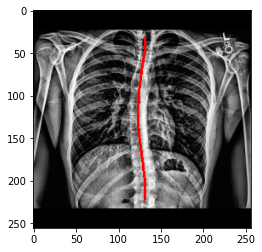

In [ ]:
plt.imshow(result1)

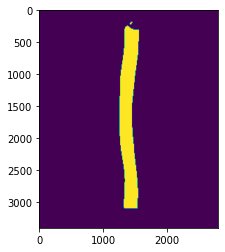

In [ ]:
plt.imshow(result2)

In [ ]:
import gradio as gr

In [ ]:
def predict2(input_img):
  input, height, width = load_image(input_img)
  
  with torch.no_grad():
    # 입력 영상 shape: (1, 1, 256, 256) <- batch, c, h, w
    input = input.to(device)  
   
    output = model(input)   # predict
    
    # for metrics (thresholding)
    logit = torch.sigmoid(output)
    output = logit.clone()
    output[output>0.5] = 1
    output[output<=0.5] = 0
       
    input = fn_tonumpy(input*255).squeeze().astype('uint8')
    output = fn_tonumpy(output).squeeze()
    
    result_image = get_result_image(input, output)
    # 예시 영상 출력
    #plt.figure(figsize=(8, 8))
    #plt.imshow(result_image)

    ############# Calculate Angle Part #############
    # 1. resize output
    output = cv.resize(output, dsize=(height, width), interpolation=cv.INTER_AREA)

  return result_image, output

In [ ]:
#interface 화면에 보여질 sample images
sample_images = [
    ["Data/CheXpert/scoliosis/1247.png"], 
    ["Data/CheXpert/scoliosis/1979.png"],
    ["Data/CheXpert/scoliosis/3570.png"],
]

iface = gr.Interface(fn=predict2, inputs=gr.inputs.Image(), outputs=[gr.outputs.Image(), gr.outputs.Image()],
                     title="KOHI 2021 project 의료영상 1팀", description="프로젝트 주제: Chest X-ray를 이용한 척추측만증 자동화 평가 모델의 개발과 검증",
                     examples = sample_images)

iface.launch(debug=True)
#iface.launch(share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://10772.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/networking.py", line 195, in predict
    prediction, durations = app.interface.process(raw_input)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 372, in process
    processed_input, return_duration=True)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 337, in run_prediction
    prediction = predict_fn(*processed_input)
  File "<ipython-input-31-38aba009cdbe>", line 2, in predict2
    input, height, width = load_image(input_img)
  File "<ipython-input-11-ea5d80210ca0>", line 2, in load_image
    input = cv.imread(path, cv.IMREAD_GRAYSCALE)
TypeError: Can't convert object of type 'numpy.ndarray' to 'str' for 'filename'
